In [5]:
from scipy.special import gamma as Gamma
from numpy import power, arange, empty, float64, log, exp, pi, diff, inner, outer, array


def calc_a(g,nu=3):
    """ 
    exponents of the polynomials of the sedov solution
    g - the polytropic gamma
    nu - the dimension
    """
    a = [0]*8
   
    a[0] = 2.0 / (nu + 2)
    a[2] = (1-g) / (2*(g-1) + nu)
    a[3] = nu / (2*(g-1) + nu)
    a[5] = 2 / (g-2)
    a[6] = g / (2*(g-1) + nu)
   
    a[1] = (((nu+2)*g)/(2.0+nu*(g-1.0)) ) * ( (2.0*nu*(2.0-g))/(g*(nu+2.0)**2) - a[2])
    a[4] = a[1]*(nu+2) / (2-g)
    a[7] = (2 + nu*(g-1))*a[1]/(nu*(2-g))
    return a

def calc_beta(v, g, nu=3):
    """ 
    beta values for the sedov solution (coefficients of the polynomials of the similarity variables) 
    v - the similarity variable
    g - the polytropic gamma
    nu- the dimension
    """

    beta = (nu+2) * (g+1) * array((0.25, (g/(g-1))*0.5,
            -(2 + nu*(g-1))/2.0 / ((nu+2)*(g+1) -2*(2 + nu*(g-1))),
     -0.5/(g-1)), dtype=float64)

    beta = outer(beta, v)

    beta += (g+1) * array((0.0,  -1.0/(g-1),
                           (nu+2) / ((nu+2)*(g+1) -2.0*(2 + nu*(g-1))),
                           1.0/(g-1)), dtype=float64).reshape((4,1))

    return beta


def sedov(t, E0, rho0, g, n=1000, nu=3):
    """ 
    solve the sedov problem
    t - the time
    E0 - the initial energy
    rho0 - the initial density
    n - number of points (10000)
    nu - the dimension
    g - the polytropic gas gamma
    """
    # the similarity variable
    v_min = 2.0 / ((nu + 2) * g)
    v_max = 4.0 / ((nu + 2) * (g + 1))

    v = v_min + arange(n) * (v_max - v_min) / (n - 1.0)

    a = calc_a(g, nu)
    beta = calc_beta(v, g=g, nu=nu)
    lbeta = log(beta)
    
    r = exp(-a[0] * lbeta[0] - a[2] * lbeta[1] - a[1] * lbeta[2])
    rho = ((g + 1.0) / (g - 1.0)) * exp(a[3] * lbeta[1] + a[5] * lbeta[3] + a[4] * lbeta[2])
    p = exp(nu * a[0] * lbeta[0] + (a[5] + 1) * lbeta[3] + (a[4] - 2 * a[1]) * lbeta[2])
    u = beta[0] * r * 4.0 / ((g + 1) * (nu + 2))
    p *= 8.0 / ((g + 1) * (nu + 2) * (nu + 2))

    # we have to take extra care at v=v_min, since this can be a special point.
    # It is not a singularity, however, the gradients of our variables (wrt v) are.
    # r -> 0, u -> 0, rho -> 0, p-> constant

    u[0] = 0.0; rho[0] = 0.0; r[0] = 0.0; p[0] = p[1]

    # volume of an n-sphere
    vol = (pi ** (nu / 2.0) / Gamma(nu / 2.0 + 1)) * power(r, nu)

    # note we choose to evaluate the integral in this way because the
    # volumes of the first few elements (i.e near v=vmin) are shrinking 
    # very slowly, so we dramatically improve the error convergence by 
    # finding the volumes exactly. This is most important for the
    # pressure integral, as this is on the order of the volume.

    # (dimensionless) energy of the model solution
    de = rho * u * u * 0.5 + p / (g - 1)
    # integrate (trapezium rule)
    q = inner(de[1:] + de[:-1], diff(vol)) * 0.5

    # the factor to convert to this particular problem
    fac = (q * (t ** nu) * rho0 / E0) ** (-1.0 / (nu + 2))

    # shock speed
    shock_speed = fac * (2.0 / (nu + 2))
    rho_s = ((g + 1) / (g - 1)) * rho0                                                                            
    r_s = shock_speed * t * (nu + 2) / 2.0
    p_s = (2.0 * rho0 * shock_speed * shock_speed) / (g + 1)
    u_s = (2.0 * shock_speed) / (g + 1)
    
    r *= fac * t
    u *= fac
    p *= fac * fac * rho0
    rho *= rho0
    return r, p, rho, u, r_s, p_s, rho_s, u_s, shock_speed


def test():
    """ draw a 3d sedov solution """
    import pylab as pl
    gamma = 5.0/3.0
    r,p,rho,u,r_s,p_s,rho_s,u_s,shock_speed = \
        sedov(t=0.05, E0=5.0, rho0=5.0, g=gamma)

    print('rho shock', rho_s)
    print('p shock', p_s)
    print('u shock', u_s)
    print('r shock', r_s)

    print('Dimensionless var (E/rho) t^2 r^-5', (5.0 /5.0)* 0.05**0.4 * r[-1]**-1.0)
    vols = (4/3.0)*pi*r*r*r
    dv = vols.copy()
    dv[1:] = diff(dv)

    # thermal and kinetic energy
    te = (p*dv/(gamma-1))
    ke = (rho*u*u*0.5*dv)
    energy = te.sum() + ke.sum()
    mass = 0.5*inner(rho[1:]+rho[:-1],dv[1:])

    print('density', mass / (4/3.0 * pi * r_s**3))
    print('energy', energy)
    print('shock speed', shock_speed)
    pl.plot(r/r_s,rho/rho_s, label=r'$\rho/\rho_s$')
    pl.plot(r/r_s,p/p_s, label=r'$p/p_s$')
    pl.plot(r/r_s,u/u_s, label=r'$u/u_s$')
    pl.legend(loc='upper left')
    pl.show()

def test2():
    """ test momentum and mass conservation in 3d """
    import pylab as pl
    r,p,rho,u,r_s,p_s,rho_s,u_s,shock_speed = \
        sedov(t=0.05, E0=5.0, rho0=5.0, g=5.0/3.0,n=10000)

    dt = 1e-5
    r2,p2,rho2,u2 = sedov(t=0.05+dt, E0=5.0, rho0=5.0, g=5.0/3.0, n=9000)[:4]

    # align the results
    from numpy import interp, gradient
    p2 = interp(r,r2,p2)
    rho2 = interp(r,r2,rho2)
    u2 = interp(r,r2,u2)

    # mass conservation
    pl.plot(r, -gradient(rho*u*r*r)/(r*r*gradient(r)), 'b', label=r'$\frac{1}{r^2}\frac{\partial}{\partial r} \rho u r^2$')
    pl.plot(r, (rho2-rho)/dt, 'k', label=r'$\frac{\partial \rho}{\partial t}$')

    # momentum conservation
    pl.plot(r, -gradient(p)/gradient(r), 'g',label=r'$-\frac{\partial p}{\partial r}$')
    pl.plot(r, rho*((u2-u)/dt+u*gradient(u)/gradient(r)), 'r',label=r'$\rho \left( \frac{\partial u}{\partial t} + u\frac{\partial u}{\partial r} \right)$')

    pl.legend(loc='lower left')
    pl.show()        

def test3():
    """ draw a 2d sedov solution """
    import pylab as pl
    r,p,rho,u,r_s,p_s,rho_s,u_s,shock_speed = sedov(t=1.2, E0=1, rho0=1, g=5.0/3.0, nu=2)

    print('rho shock', rho_s)
    print('p shock', p_s)
    print('u shock', u_s)
    print('r shock', r_s)
  
    area = pi*r*r
    dv = area.copy()
    dv[1:] = diff(dv)

    # thermal and kinetic energy
    te = (p*dv/(5.0/3.0-1))
    ke = (rho*u*u*0.5*dv)
    #pl.plot(arange(te.size), ke, 'x')
    #pl.show()
    print('r0', r[:2])
    energy = te.sum() + ke.sum()
    mass = 0.5*inner(rho[1:]+rho[:-1],dv[1:])

    print('density', mass / (pi * r_s**2))
    print('energy', energy)
    print('shock speed', shock_speed)
    pl.plot(r/r_s,rho/rho_s, 'b,',label=r'$\rho/\rho_s$')
    pl.plot(r/r_s,p/p_s,'r',label=r'$p/p_s$')
    pl.plot(r/r_s,u/u_s, 'g,',label=r'$u/u_s$')
    pl.plot(r,rho,'b',label='$\\rho$')
    pl.plot(r,u,'b',label='$u$')
    pl.plot(r,p,'b',label='$P$')
    pl.legend(loc='upper left')
#    pl.xlim(0,2)
#    pl.ylim(0,5)
    pl.show()


rho shock 20.0
p shock 28.97597527862182
u shock 2.084801259543286
r shock 0.34746687659054776
Dimensionless var (E/rho) t^2 r^-5 0.868309577556624
density 5.000220845432969
energy 5.004759500170177
shock speed 2.779735012724382


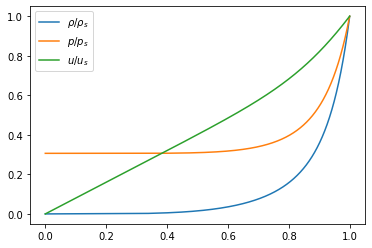

In [6]:
test()

C:\Users\Drishika Nadella\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: divide by zero encountered in true_divide


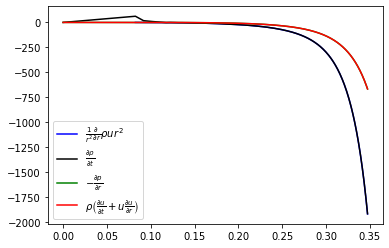

In [7]:
test2()

rho shock 4.0
p shock 0.20800130135447628
u shock 0.39496958872279925
r shock 1.2639026839129577
r0 [0.         0.30745828]
density 1.0001316058925762
energy 1.0009102465291877
shock speed 0.5266261182970657


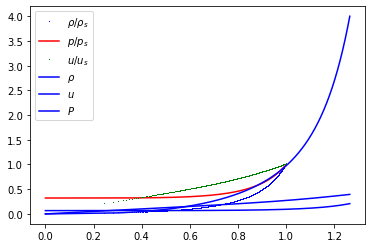

In [8]:
test3()
